# MeanCounts in my smFISH data validation set vs RNAseq FPKM

- Cells: BMD Macrophages
- Genotypes: WT, Rad21KO
- Timepoints: 0h, 2h, 8h, 10ng/ml LPS
- Replicates: 3
- Genes: 
 - Set1: Actb, Il12b, Stat1
 - Set2: Tnf, Cd40, Atf3

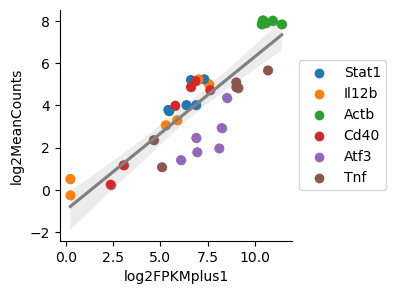

In [1]:
ENV["Code"] = "../../Code"
[push!(LOAD_PATH, string(ENV["Code"],"/", ii)) for ii in readdir(ENV["Code"])]
include("../Databases/smFISH_validation.jl")

using DataFrames
using Seaborn
using NoLongerProblems_Pandas
using NoLongerProblems
using CSV
using RCall
import Pandas
using PrettyPlotting
using NoLongerProblems_Pandas
using PyPlot
import Pandas
using Statistics, PyCall

# Calculate mean per sample and replicate
apply_func_per_sample_replicate = smFISH_validation.apply_func_per_sample_replicate
tb_set1 = smFISH_validation.apply_func_per_sample_replicate(smFISH_validation.smFISHdata("actb"), Statistics.mean, "MeanCounts")
tb_set2 = smFISH_validation.apply_func_per_sample_replicate(smFISH_validation.smFISHdata("atf3"), Statistics.mean, "MeanCounts")
tb = join_in_all_common_columns(tb_set1, tb_set2)
CSV.write("smFISH_MEAN.csv", tb)


# Add RNAseq FPKM to table
include("../Databases/Cuartero2018.jl")

fpkm = Cuartero2018.get_mean_FPKM();
tab = CSV.read("smFISH_MEAN.csv", DataFrames.DataFrame)
tab[!,:Sample_Gene] = tab[!,:Sample] .*"__".*tab[!,:Gene]

meantab = DataFrames.DataFrame(Sample_Gene = unique(tab[!,:Sample_Gene]))
meantab[!,:MeanCounts] = [mean(tab[tab[!,:Sample_Gene] .== ii, :MeanCounts]) for ii in meantab[!,:Sample_Gene]]
meantab[!,:Sample] = [split(ii, "__")[1] for ii in meantab[!,:Sample_Gene] ]
meantab[!,:Gene] = [split(ii, "__")[2] for ii in meantab[!,:Sample_Gene] ]

for name in names(fpkm)
    if startswith(string(name), "FL") 
      rename!(fpkm, Symbol(string(name))=>Symbol(replace(string(name), "FL"=> "Rad21KO")))
    end
end

fpkms = []
for ii in meantab[!,:Sample_Gene]
    samp = Symbol(split(ii, "__")[1])
    geneind = fpkm[!,:GeneSymbol].==split(ii, "__")[2]
     push!(fpkms, fpkm[geneind, samp][1])
end

meantab[!,:MeanFPKM] = fpkms
meantab[!,:log2MeanCounts] = log2.(meantab[!,:MeanCounts])
meantab[!,:log2FPKMplus1] = log2.(meantab[!,:MeanFPKM].+1)

# Plot Data

pd = Pandas.DataFrame(meantab)
figure(figsize = (3, 3))
py"""
import seaborn as sns
sns.regplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", color = "grey")
sns.scatterplot(data = $pd, x = "log2FPKMplus1", y = "log2MeanCounts", hue = "Gene", s = 50, linewidth = 0)
"""
pretty_axes2()
legend_out_of_plot()
PrettyPlotting.savefigwithtext("log2FPKM_log2MeanCounts.svg")

### Correlation test (called from R)

In [2]:
R"""
tb <- $meantab
cor.test(tb$log2MeanCounts, tb$log2FPKM)
"""

RObject{VecSxp}

	Pearson's product-moment correlation

data:  tb$log2MeanCounts and tb$log2FPKM
t = 9.7105, df = 34, p-value = 2.462e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7361057 0.9252452
sample estimates:
      cor 
0.8573117 



In [3]:
CSV.write("../SourceData/Fig1b.csv", meantab)
import Pkg; Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [7e6ae17a] BioSequences v2.0.5
  [336ed68f] CSV v0.9.11
  [8f4d0f93] Conda v1.5.2
  [a93c6f00] DataFrames v1.2.2
  [31c24e10] Distributions v0.25.28
  [c2308a5c] FASTX v1.2.0
  [09f84164] HypothesisTests v0.10.6
  [7073ff75] IJulia v1.23.2
  [916415d5] Images v0.24.1
  [96684042] InformationMeasures v0.3.1
  [10e44e05] MATLAB v0.8.2
  [f8716d33] MultipleTesting v0.5.0
  [92933f4c] ProgressMeter v1.7.1
  [438e738f] PyCall v1.92.5
  [d330b81b] PyPlot v2.10.0
  [6f49c342] RCall v0.13.12
  [d2ef9438] Seaborn v1.0.0
  [2913bbd2] StatsBase v0.33.13
